In [1]:
googlecolab = True

if googlecolab:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
    !pip install Pillow==4.1.1

  ERROR: HTTP error 403 while getting http://download.pytorch.org/whl/cu101/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
  ERROR: Could not install requirement torch==0.4.1 from http://download.pytorch.org/whl/cu101/torch-0.4.1-cp36-cp36m-linux_x86_64.whl because of error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu101/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
ERROR: Could not install requirement torch==0.4.1 from http://download.pytorch.org/whl/cu101/torch-0.4.1-cp36-cp36m-linux_x86_64.whl because of HTTP error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu101/torch-0.4.1-cp36-cp36m-linux_x86_64.whl for URL http://download.pytorch.org/whl/cu101/torch-0.4.1-cp36-cp36m-linux_x86_64.whl


In [0]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [3]:
## Data loading

workers = 4 # Number of workers for dataloader (/!\ set to 4 when you're done debugging)

## Architecture

nz = 100 # Size of z latent vector (i.e. size of generator input)
# nz = 10
# nz = 1000
ndf = 64 # Base size of feature maps in discriminator
ngf = 64 # Base size of feature maps in generator

## Optimization

lrD = 0.0002 # Learning rate for the discriminator
lrG = 0.0002 # Learning rate for the generator
# lrG = 0.002
beta1G = 0.5 # Momentum beta1 for the discriminator
beta1D = 0.5 # Momentum beta1 for the generator

## Training

batch_size = 256 # Images per batch
nb_update_D = 1 # Number of sub-steps of discriminator optim. at each step
# nb_update_D = 10
nb_update_G = 1 # Number of sub-steps of generator optim. at each step
# nb_update_G = 10
steps = 8000 # Number of global steps in the training loop
nb_epochs = None # Number of epochs, leave "None" if you want to set the number of "steps" (i.e. batches)
# nb_epochs = 30 

if nb_epochs is None:
    nb_epochs = (steps * batch_size) / (nb_update_D * 202000)
else:
    steps = int(nb_epochs * nb_update_D * 202000 / batch_size)
print("Doing %.1f epochs in %d steps" % (nb_epochs, steps))

Doing 10.1 epochs in 8000 steps


In [4]:
%%sh
# Dataset loading

 if ! [ -d "/tmp/celeba/img_align_celeba64" ] ; then
     mkdir /tmp/celeba64
     cd /tmp/celeba64
     wget http://webia.lip6.fr/~robert/cours/rdfia/celeba64.zip
     unzip celeba64.zip
fi

# For 64x64 images, replace celeba with celeba64 everywhere

Streaming output truncated to the last 5000 lines.
 46200K .......... .......... .......... .......... .......... 15% 91.0M 11s
 46250K .......... .......... .......... .......... .......... 15%  129M 11s
 46300K .......... .......... .......... .......... .......... 15%  117M 11s
 46350K .......... .......... .......... .......... .......... 15%  131M 11s
 46400K .......... .......... .......... .......... .......... 15% 84.6M 11s
 46450K .......... .......... .......... .......... .......... 15% 98.3M 11s
 46500K .......... .......... .......... .......... .......... 15%  145M 11s
 46550K .......... .......... .......... .......... .......... 15%  115M 11s
 46600K .......... .......... .......... .......... .......... 15%  111M 11s
 46650K .......... .......... .......... .......... .......... 15%  117M 11s
 46700K .......... .......... .......... .......... .......... 15% 96.5M 11s
 46750K .......... .......... .......... .......... .......... 15%  145M 11s
 46800K .......... ......

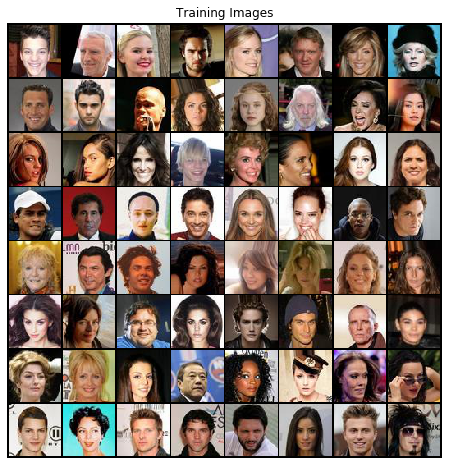

In [5]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root="/tmp/celeba64",
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # input is (3) x 64 x 64
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input)



class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (3) x 64 x 64
        )

    def forward(self, input):
        return self.model(input)

In [7]:
# Create the models
netG = Generator().to(device)
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
netG.apply(weights_init)
netD.apply(weights_init)

# Print the models
print(netG)
print(netD)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [8]:
# TODO test you models to check if they have the right shape
z = torch.zeros(10, nz, 1, 1).to(device)
x = torch.zeros(10, 3, 64, 64).to(device)
print(netG(z).shape) # expected: [10, 3, 64, 64]
print(netD(x).shape) # expected: [10, 1, 1, 1]

torch.Size([10, 3, 64, 64])
torch.Size([10, 1, 1, 1])


In [0]:
# Prior P(z). Returns a Gaussian random tensor of shape (batch_size, nz, 1, 1)
def get_noise(batch_size):
    normal_distrib = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
    noise = normal_distrib.sample((batch_size,nz,1))
    return noise.to(device)

# Create the criterion function that will take (y_hat, y) as input
criterion = torch.nn.BCELoss()

# Setup Adam optimizers for D and G
optimizerD = torch.optim.Adam(netD.parameters(), lr=lrD, betas=(beta1D,0.999)) # take netD.parameters(), use the right lr and beta1
# optimizerD = torch.optim.Adam(netD.parameters(), lr=lrD)
# rajouter optimizer avec momentum modifié 
# optimizerD = torch.optim.Adam(netD.parameters(), lr=1e-4)
# optimizerD = torch.optim.Adam(netD.parameters(), lr=1e-2)

optimizerG = torch.optim.Adam(netG.parameters(), lr=lrG, betas=(beta1G,0.999)) # same for G
# optimizerG = torch.optim.Adam(netG.parameters(), lr=lrG)
# rajouter optimizer avec momentum modifié 
# optimizerG = torch.optim.Adam(netG.parameters(), lr=1e-4)
# optimizerG = torch.optim.Adam(netG.parameters(), lr=1e-2)
# Note that adam's betas is a tuple, set the second element of the tuple to 0.999 for both optimizers.

In [0]:
# Data format / batch creation functions

fixed_noise = get_noise(196) # Create a fixed random vector sampled from a Gaussian, will be used during train for viz
real_label = 1
fake_label = 0
iterator = iter(dataloader)

# returns a batch of real images from the dataset (iterates infinitely on the dataset)
def get_batch_real():
    global iterator
    try:
        x_real = next(iterator)[0].to(device)
    except:
        iterator = iter(dataloader)
        x_real = next(iterator)[0].to(device)
    y_real = torch.full((x_real.size(0),), real_label, device=device)
    return x_real, y_real

# TODO
# returns a batch of generated images and training targets y_fake
# Note that the targets y_fake will be different is train_G is True or False
def get_batch_fake(train_G=False):
    z = get_noise(batch_size)
    x_fake = netG(z) # TODO generate images from z
    if(train_G):
      y_fake = torch.ones((batch_size),requires_grad=False) 
    else:
      y_fake = torch.zeros((batch_size),requires_grad=False) # TODO create targets, depends on train_G
    return x_fake, y_fake.to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[    0/ 8000]	Loss_D: 1.5510	Loss_G: 5.2772	D(x): 0.5611	D(G(z)): 0.5175


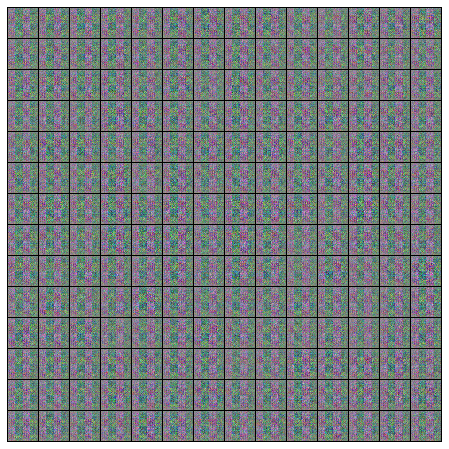

[   25/ 8000]	Loss_D: 2.7641	Loss_G: 19.9960	D(x): 0.9566	D(G(z)): 0.8898
[   50/ 8000]	Loss_D: 0.3755	Loss_G: 21.3667	D(x): 0.8457	D(G(z)): 0.0000
[   75/ 8000]	Loss_D: 0.5869	Loss_G: 10.9477	D(x): 0.9622	D(G(z)): 0.3518
[  100/ 8000]	Loss_D: 0.6147	Loss_G: 4.7526	D(x): 0.7116	D(G(z)): 0.0081
[  125/ 8000]	Loss_D: 2.1857	Loss_G: 7.4998	D(x): 0.3088	D(G(z)): 0.0007
[  150/ 8000]	Loss_D: 0.5488	Loss_G: 2.4195	D(x): 0.7739	D(G(z)): 0.1417
[  175/ 8000]	Loss_D: 0.6368	Loss_G: 2.3038	D(x): 0.6489	D(G(z)): 0.0333
[  200/ 8000]	Loss_D: 1.0466	Loss_G: 9.1580	D(x): 0.9354	D(G(z)): 0.5354
[  225/ 8000]	Loss_D: 1.0789	Loss_G: 8.3442	D(x): 0.9123	D(G(z)): 0.5645
[  250/ 8000]	Loss_D: 0.6882	Loss_G: 7.0046	D(x): 0.9123	D(G(z)): 0.3956
[  275/ 8000]	Loss_D: 0.3530	Loss_G: 2.6247	D(x): 0.8359	D(G(z)): 0.1112
[  300/ 8000]	Loss_D: 0.5419	Loss_G: 3.1495	D(x): 0.8310	D(G(z)): 0.2392
[  325/ 8000]	Loss_D: 0.7828	Loss_G: 4.6716	D(x): 0.7993	D(G(z)): 0.3740
[  350/ 8000]	Loss_D: 0.6285	Loss_G: 3.6484	D(x)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([102])) that is different to the input size (torch.Size([102, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[  800/ 8000]	Loss_D: 0.3369	Loss_G: 3.8269	D(x): 0.8288	D(G(z)): 0.0869
[  825/ 8000]	Loss_D: 0.6450	Loss_G: 3.9590	D(x): 0.7678	D(G(z)): 0.2384
[  850/ 8000]	Loss_D: 0.7519	Loss_G: 6.4537	D(x): 0.8962	D(G(z)): 0.4091
[  875/ 8000]	Loss_D: 0.6938	Loss_G: 3.6451	D(x): 0.6568	D(G(z)): 0.0843
[  900/ 8000]	Loss_D: 0.5227	Loss_G: 6.6590	D(x): 0.9391	D(G(z)): 0.3027
[  925/ 8000]	Loss_D: 0.3529	Loss_G: 4.7804	D(x): 0.8433	D(G(z)): 0.1311
[  950/ 8000]	Loss_D: 0.6575	Loss_G: 5.9280	D(x): 0.9351	D(G(z)): 0.3777
[  975/ 8000]	Loss_D: 0.6876	Loss_G: 6.8927	D(x): 0.8818	D(G(z)): 0.3756
[ 1000/ 8000]	Loss_D: 0.2700	Loss_G: 3.2956	D(x): 0.9151	D(G(z)): 0.1223


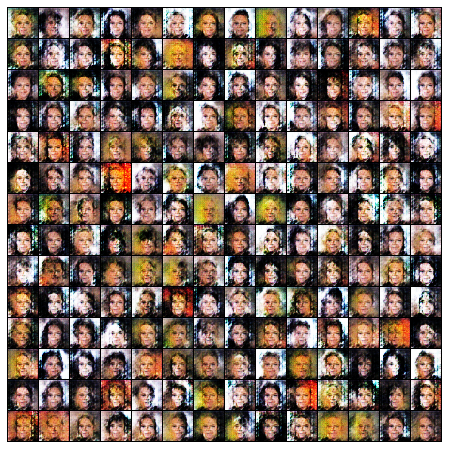

[ 1025/ 8000]	Loss_D: 0.6074	Loss_G: 5.4034	D(x): 0.6860	D(G(z)): 0.0235
[ 1050/ 8000]	Loss_D: 0.3670	Loss_G: 4.5150	D(x): 0.7751	D(G(z)): 0.0362
[ 1075/ 8000]	Loss_D: 0.4091	Loss_G: 6.3834	D(x): 0.9052	D(G(z)): 0.2338
[ 1100/ 8000]	Loss_D: 0.3824	Loss_G: 2.6553	D(x): 0.7666	D(G(z)): 0.0237
[ 1125/ 8000]	Loss_D: 0.5995	Loss_G: 6.7814	D(x): 0.9321	D(G(z)): 0.3454
[ 1150/ 8000]	Loss_D: 0.8389	Loss_G: 5.9269	D(x): 0.5413	D(G(z)): 0.0037
[ 1175/ 8000]	Loss_D: 1.0300	Loss_G: 8.5617	D(x): 0.9404	D(G(z)): 0.5425
[ 1200/ 8000]	Loss_D: 0.9109	Loss_G: 2.6347	D(x): 0.5352	D(G(z)): 0.0188
[ 1225/ 8000]	Loss_D: 0.4561	Loss_G: 3.0745	D(x): 0.7279	D(G(z)): 0.0482
[ 1250/ 8000]	Loss_D: 1.1864	Loss_G: 0.6108	D(x): 0.4586	D(G(z)): 0.0486
[ 1275/ 8000]	Loss_D: 0.2771	Loss_G: 3.7985	D(x): 0.8551	D(G(z)): 0.0733
[ 1300/ 8000]	Loss_D: 0.5874	Loss_G: 2.7366	D(x): 0.6800	D(G(z)): 0.0624
[ 1325/ 8000]	Loss_D: 0.5792	Loss_G: 8.0597	D(x): 0.9595	D(G(z)): 0.3517
[ 1350/ 8000]	Loss_D: 0.4136	Loss_G: 4.7242	D(x): 0

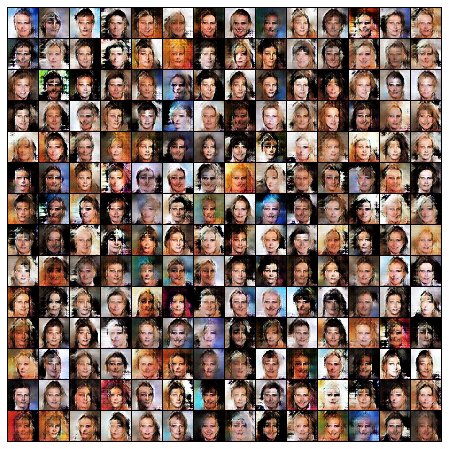

[ 2025/ 8000]	Loss_D: 0.5606	Loss_G: 2.8211	D(x): 0.6680	D(G(z)): 0.0513
[ 2050/ 8000]	Loss_D: 0.2891	Loss_G: 3.8044	D(x): 0.9049	D(G(z)): 0.1525
[ 2075/ 8000]	Loss_D: 0.5646	Loss_G: 5.4463	D(x): 0.9111	D(G(z)): 0.3211
[ 2100/ 8000]	Loss_D: 0.5477	Loss_G: 5.9439	D(x): 0.9119	D(G(z)): 0.3081
[ 2125/ 8000]	Loss_D: 0.4538	Loss_G: 3.9594	D(x): 0.8316	D(G(z)): 0.1988
[ 2150/ 8000]	Loss_D: 0.3454	Loss_G: 3.1314	D(x): 0.8562	D(G(z)): 0.1424
[ 2175/ 8000]	Loss_D: 0.3457	Loss_G: 5.1782	D(x): 0.9349	D(G(z)): 0.2084
[ 2200/ 8000]	Loss_D: 0.2695	Loss_G: 3.5497	D(x): 0.8756	D(G(z)): 0.1089
[ 2225/ 8000]	Loss_D: 0.3208	Loss_G: 4.1861	D(x): 0.8912	D(G(z)): 0.1639
[ 2250/ 8000]	Loss_D: 0.2916	Loss_G: 3.3336	D(x): 0.8374	D(G(z)): 0.0798
[ 2275/ 8000]	Loss_D: 0.2523	Loss_G: 4.1585	D(x): 0.8438	D(G(z)): 0.0533
[ 2300/ 8000]	Loss_D: 0.7916	Loss_G: 6.1889	D(x): 0.9190	D(G(z)): 0.4494
[ 2325/ 8000]	Loss_D: 0.3701	Loss_G: 3.4818	D(x): 0.8199	D(G(z)): 0.1249
[ 2350/ 8000]	Loss_D: 0.2465	Loss_G: 3.6141	D(x): 0

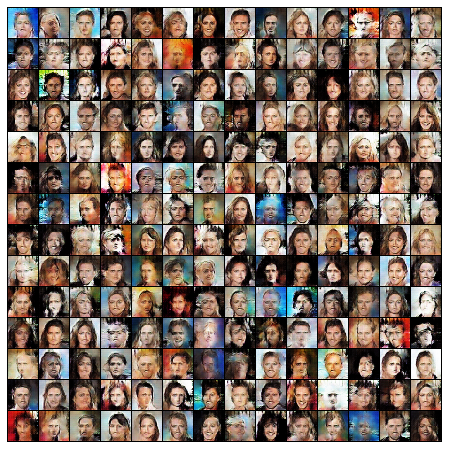

[ 3025/ 8000]	Loss_D: 0.3397	Loss_G: 3.3159	D(x): 0.8305	D(G(z)): 0.1166
[ 3050/ 8000]	Loss_D: 0.8280	Loss_G: 6.7914	D(x): 0.9768	D(G(z)): 0.5024
[ 3075/ 8000]	Loss_D: 0.4032	Loss_G: 3.0533	D(x): 0.7284	D(G(z)): 0.0331
[ 3100/ 8000]	Loss_D: 0.2707	Loss_G: 2.8481	D(x): 0.8719	D(G(z)): 0.1067
[ 3125/ 8000]	Loss_D: 0.4339	Loss_G: 2.7140	D(x): 0.7953	D(G(z)): 0.1483
[ 3150/ 8000]	Loss_D: 1.2537	Loss_G: 6.1001	D(x): 0.9886	D(G(z)): 0.6374
[ 3175/ 8000]	Loss_D: 0.2612	Loss_G: 3.5584	D(x): 0.8968	D(G(z)): 0.1291
[ 3200/ 8000]	Loss_D: 0.2431	Loss_G: 3.4988	D(x): 0.8508	D(G(z)): 0.0676
[ 3225/ 8000]	Loss_D: 0.2693	Loss_G: 2.5523	D(x): 0.8246	D(G(z)): 0.0492
[ 3250/ 8000]	Loss_D: 0.9520	Loss_G: 7.2482	D(x): 0.9750	D(G(z)): 0.5039
[ 3275/ 8000]	Loss_D: 0.3894	Loss_G: 3.8180	D(x): 0.8834	D(G(z)): 0.2096
[ 3300/ 8000]	Loss_D: 0.2937	Loss_G: 3.7067	D(x): 0.8936	D(G(z)): 0.1469
[ 3325/ 8000]	Loss_D: 3.7107	Loss_G: 2.4444	D(x): 0.0481	D(G(z)): 0.0002
[ 3350/ 8000]	Loss_D: 0.4403	Loss_G: 3.6053	D(x): 0

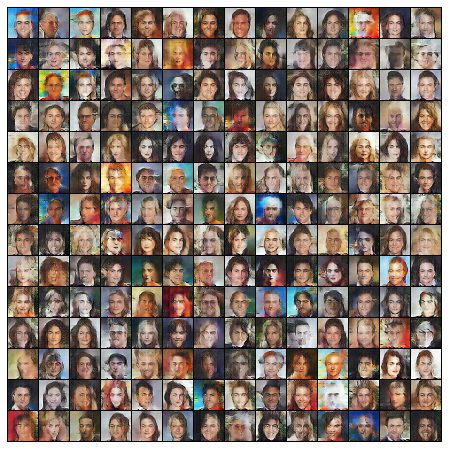

[ 4025/ 8000]	Loss_D: 3.0128	Loss_G: 7.7446	D(x): 0.9985	D(G(z)): 0.9126
[ 4050/ 8000]	Loss_D: 0.3031	Loss_G: 2.4870	D(x): 0.8278	D(G(z)): 0.0864
[ 4075/ 8000]	Loss_D: 0.5741	Loss_G: 5.3874	D(x): 0.9087	D(G(z)): 0.3397
[ 4100/ 8000]	Loss_D: 0.2270	Loss_G: 3.3368	D(x): 0.8470	D(G(z)): 0.0433
[ 4125/ 8000]	Loss_D: 0.2289	Loss_G: 3.7648	D(x): 0.8979	D(G(z)): 0.1020
[ 4150/ 8000]	Loss_D: 0.4770	Loss_G: 3.9818	D(x): 0.8476	D(G(z)): 0.2278
[ 4175/ 8000]	Loss_D: 0.2839	Loss_G: 3.9995	D(x): 0.9183	D(G(z)): 0.1641
[ 4200/ 8000]	Loss_D: 0.3371	Loss_G: 3.2530	D(x): 0.8298	D(G(z)): 0.1129
[ 4225/ 8000]	Loss_D: 0.4239	Loss_G: 4.9046	D(x): 0.8867	D(G(z)): 0.2344
[ 4250/ 8000]	Loss_D: 0.8472	Loss_G: 1.5448	D(x): 0.4911	D(G(z)): 0.0202
[ 4275/ 8000]	Loss_D: 0.3179	Loss_G: 2.9238	D(x): 0.7876	D(G(z)): 0.0474
[ 4300/ 8000]	Loss_D: 0.7165	Loss_G: 3.4035	D(x): 0.8989	D(G(z)): 0.3919
[ 4325/ 8000]	Loss_D: 0.2134	Loss_G: 3.2442	D(x): 0.9228	D(G(z)): 0.1153
[ 4350/ 8000]	Loss_D: 0.3976	Loss_G: 2.6243	D(x): 0

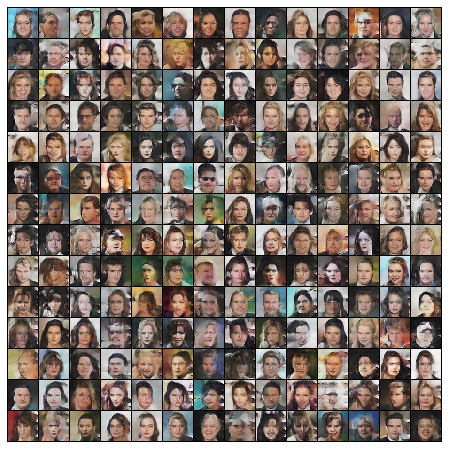

[ 5025/ 8000]	Loss_D: 0.6075	Loss_G: 2.0987	D(x): 0.6152	D(G(z)): 0.0289
[ 5050/ 8000]	Loss_D: 0.1822	Loss_G: 3.9939	D(x): 0.9428	D(G(z)): 0.1078
[ 5075/ 8000]	Loss_D: 0.6125	Loss_G: 2.3283	D(x): 0.6819	D(G(z)): 0.1240
[ 5100/ 8000]	Loss_D: 0.5178	Loss_G: 2.1055	D(x): 0.6870	D(G(z)): 0.0789
[ 5125/ 8000]	Loss_D: 0.2952	Loss_G: 2.8464	D(x): 0.8190	D(G(z)): 0.0670
[ 5150/ 8000]	Loss_D: 0.2637	Loss_G: 3.9551	D(x): 0.9299	D(G(z)): 0.1636
[ 5175/ 8000]	Loss_D: 0.3573	Loss_G: 3.4997	D(x): 0.8926	D(G(z)): 0.1926
[ 5200/ 8000]	Loss_D: 0.3084	Loss_G: 3.2889	D(x): 0.8895	D(G(z)): 0.1591
[ 5225/ 8000]	Loss_D: 0.2449	Loss_G: 4.0587	D(x): 0.9283	D(G(z)): 0.1457
[ 5250/ 8000]	Loss_D: 0.1572	Loss_G: 4.0062	D(x): 0.9294	D(G(z)): 0.0731
[ 5275/ 8000]	Loss_D: 0.7144	Loss_G: 2.3219	D(x): 0.5616	D(G(z)): 0.0217
[ 5300/ 8000]	Loss_D: 0.6743	Loss_G: 7.7871	D(x): 0.9703	D(G(z)): 0.4382
[ 5325/ 8000]	Loss_D: 0.3187	Loss_G: 2.1234	D(x): 0.8085	D(G(z)): 0.0814
[ 5350/ 8000]	Loss_D: 1.8902	Loss_G: 2.6264	D(x): 0

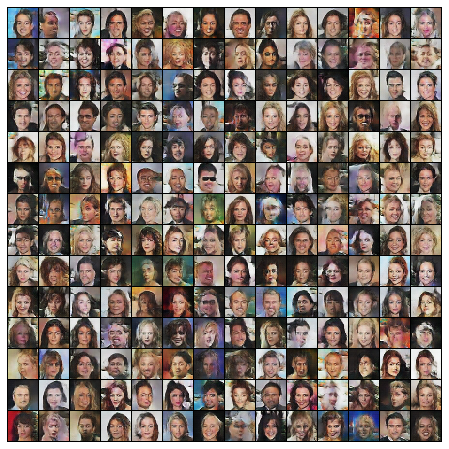

[ 6025/ 8000]	Loss_D: 0.2525	Loss_G: 3.5276	D(x): 0.9275	D(G(z)): 0.1466
[ 6050/ 8000]	Loss_D: 0.4046	Loss_G: 1.8330	D(x): 0.7457	D(G(z)): 0.0592
[ 6075/ 8000]	Loss_D: 0.1755	Loss_G: 3.1806	D(x): 0.9275	D(G(z)): 0.0890
[ 6100/ 8000]	Loss_D: 0.2478	Loss_G: 2.3310	D(x): 0.8493	D(G(z)): 0.0653
[ 6125/ 8000]	Loss_D: 2.5691	Loss_G: 0.0412	D(x): 0.1521	D(G(z)): 0.0330
[ 6150/ 8000]	Loss_D: 1.6061	Loss_G: 6.6862	D(x): 0.9943	D(G(z)): 0.7268
[ 6175/ 8000]	Loss_D: 0.2772	Loss_G: 5.0148	D(x): 0.9819	D(G(z)): 0.2124
[ 6200/ 8000]	Loss_D: 0.2418	Loss_G: 2.6427	D(x): 0.8613	D(G(z)): 0.0743
[ 6225/ 8000]	Loss_D: 0.2165	Loss_G: 3.8389	D(x): 0.9216	D(G(z)): 0.1157
[ 6250/ 8000]	Loss_D: 0.2585	Loss_G: 2.3037	D(x): 0.8465	D(G(z)): 0.0684
[ 6275/ 8000]	Loss_D: 0.2474	Loss_G: 2.9895	D(x): 0.8503	D(G(z)): 0.0355
[ 6300/ 8000]	Loss_D: 0.2706	Loss_G: 3.4376	D(x): 0.8773	D(G(z)): 0.1104
[ 6325/ 8000]	Loss_D: 0.1711	Loss_G: 4.4411	D(x): 0.8863	D(G(z)): 0.0418
[ 6350/ 8000]	Loss_D: 0.1598	Loss_G: 3.0995	D(x): 0

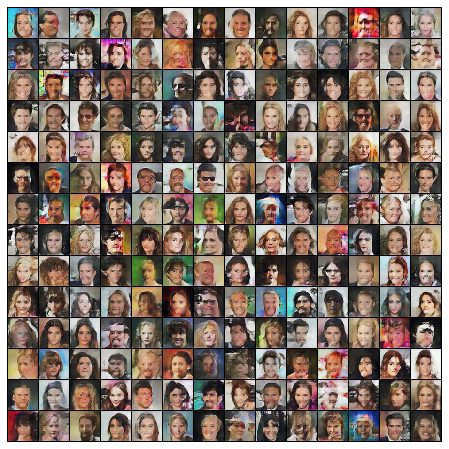

[ 7025/ 8000]	Loss_D: 0.3231	Loss_G: 3.2483	D(x): 0.7828	D(G(z)): 0.0426
[ 7050/ 8000]	Loss_D: 0.3173	Loss_G: 2.4175	D(x): 0.8165	D(G(z)): 0.0800
[ 7075/ 8000]	Loss_D: 0.1659	Loss_G: 3.2680	D(x): 0.9452	D(G(z)): 0.0987
[ 7100/ 8000]	Loss_D: 0.1778	Loss_G: 3.6744	D(x): 0.8616	D(G(z)): 0.0173
[ 7125/ 8000]	Loss_D: 0.1032	Loss_G: 4.0325	D(x): 0.9401	D(G(z)): 0.0381
[ 7150/ 8000]	Loss_D: 0.1864	Loss_G: 2.8021	D(x): 0.8769	D(G(z)): 0.0455
[ 7175/ 8000]	Loss_D: 4.6854	Loss_G: 0.6090	D(x): 0.0159	D(G(z)): 0.0004
[ 7200/ 8000]	Loss_D: 0.2001	Loss_G: 3.4897	D(x): 0.8862	D(G(z)): 0.0621
[ 7225/ 8000]	Loss_D: 0.1792	Loss_G: 4.3120	D(x): 0.9477	D(G(z)): 0.1100
[ 7250/ 8000]	Loss_D: 0.2871	Loss_G: 2.5782	D(x): 0.8238	D(G(z)): 0.0652
[ 7275/ 8000]	Loss_D: 0.4947	Loss_G: 3.5875	D(x): 0.7779	D(G(z)): 0.1680
[ 7300/ 8000]	Loss_D: 1.5176	Loss_G: 2.0144	D(x): 0.2992	D(G(z)): 0.0082
[ 7325/ 8000]	Loss_D: 0.3334	Loss_G: 2.3317	D(x): 0.7636	D(G(z)): 0.0333
[ 7350/ 8000]	Loss_D: 0.1907	Loss_G: 3.6616	D(x): 0

In [11]:
img_list = []
G_losses = []
D_losses = []

for i in range(steps):
    
    ########
    # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    for _ in range(nb_update_D):
        netD.zero_grad()
        
        # Create batches
        x_real, y_real = get_batch_real()
        x_fake, y_fake = get_batch_fake()
        
        # Forward 
        y_hat_real = netD(x_real) # TODO
        y_hat_fake = netD(x_fake) # TODO
        errD = criterion(y_hat_real,y_real)+criterion(y_hat_fake,y_fake)       # TODO sum of criterion of real and fake samples
        
        # Backward
        # TODO backward & optimization step on D
        errD.backward()
        optimizerD.step()
        
        # Compute / save metricsthe derivative for 'target' is not implemented
        avg_output_for_real = y_hat_real.mean().item()
        avg_output_for_fake = y_hat_fake.mean().item()    
        D_losses.append(errD.item())
      


    ########
    # Update G network: maximize log(D(G(z)))
    for _ in range(nb_update_G):
        netG.zero_grad()
        
        # TODO: forward + backward
        # NOTE: use errG as name for your loss variable, like errD above
        x_fake, y_fake = get_batch_fake(train_G=True)

        
        y_hat_fake = netD(x_fake)
        errG = criterion(y_hat_fake,y_fake)
        # errG = torch.mean(torch.log(1 - y_hat_fake)) 

        errG.backward()
        optimizerG.step()
        # Compute / save metrics
        G_losses.append(errG.item())
        
    
    ########
    # Logs
    if i % 25 == 0:
        print('[%5d/%5d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
              % (i, steps, errD.item(), errG.item(), avg_output_for_real, avg_output_for_fake))

    if i % 1000 == 0:
        with torch.no_grad():
            x_fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(x_fake, padding=2, normalize=True, nrow=14))
        plt.figure(figsize=(8,8))
        plt.imshow(np.transpose(img_list[-1],(1,2,0)))
        plt.axis("off")
        plt.show()

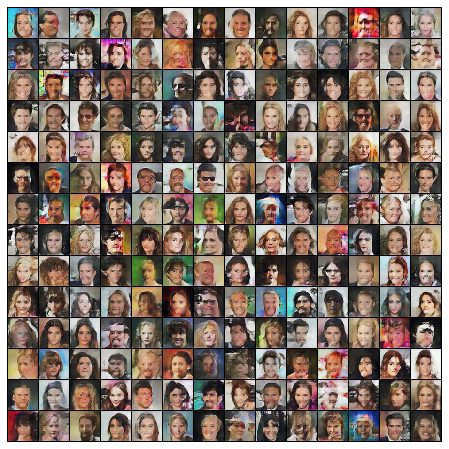

In [12]:
with torch.no_grad():
    x_fake = netG(fixed_noise).detach().cpu()
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.axis("off")
plt.show()

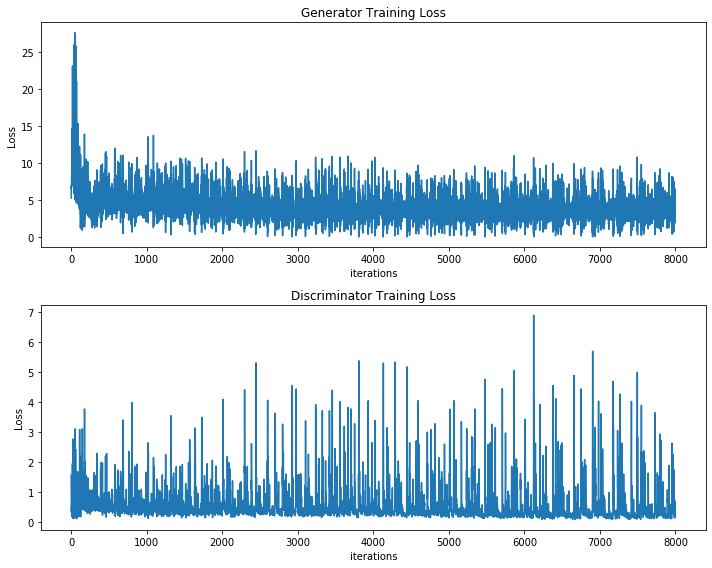

In [13]:
# Loss evolution
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("Generator Training Loss")
plt.plot(G_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")

plt.subplot(2,1,2)
plt.title("Discriminator Training Loss")
plt.plot(D_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()